In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports.py

In [9]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=4, repeat_action_probability=0.0)
obs, info = env.reset()

In [10]:
from threaded_atari_v2 import *

In [11]:
archive = np.load('./archive.npy', allow_pickle=True).item()
len(archive)

8902

In [12]:
cells = list(archive.values())

In [13]:
min([len(cell.trajectory) for cell in cells])

1

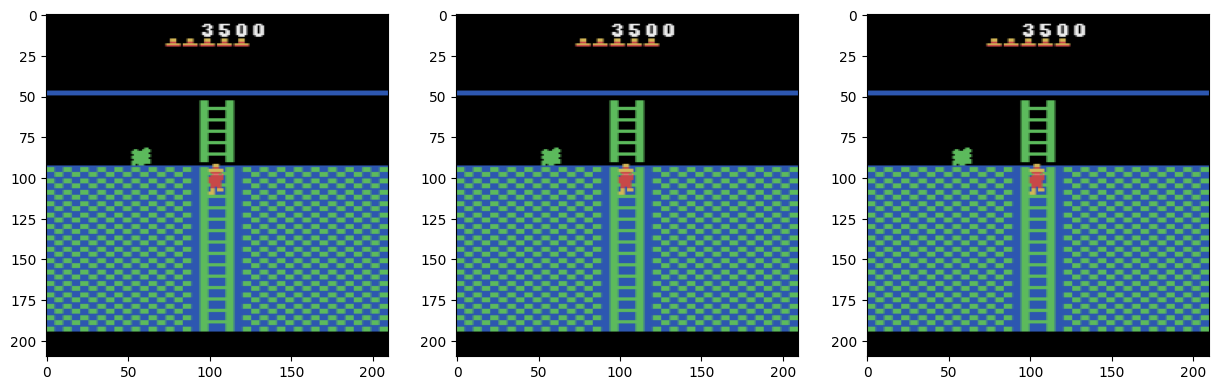

In [511]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=1, repeat_action_probability=0.0)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=210, grayscale_obs=False)
env.reset()

env.restore_state(cell.ram)
obs1, _, _, _, _ = env.step(0)
ram1 = env.ale.getRAM()

env.reset()
for a in cell.trajectory[:]:
    env.step(a)
obs2, _, _, _, _ = env.step(0)
ram2 = env.ale.getRAM()

# assert np.allclose(ram1, ram2)
# assert np.allclose(obs1, obs2)

env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env.reset()
for a in cell.trajectory[:]:
    env.step(np.array([a]))
obs3, _, _, _, _ = env.step(np.array([0]))
obs3 = rearrange(obs3, '1 c h w -> h w c')

plt.figure(figsize=(15, 5))
plt.subplot(131);plt.imshow(obs1)
plt.subplot(132);plt.imshow(obs2)
plt.subplot(133);plt.imshow(obs3)

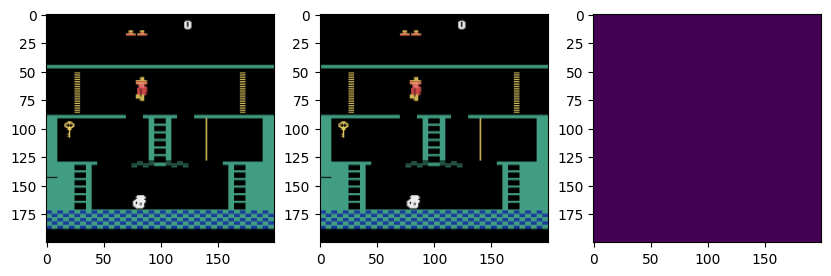

In [455]:
env = gym.make(f"ALE/MontezumaRevenge-v5", frameskip=1, repeat_action_probability=0.0)
env = gym.wrappers.AtariPreprocessing(env, noop_max=1, frame_skip=4, screen_size=200, grayscale_obs=False)
obs1, _ = env.reset()
for i in range(300):
    obs1, _, _, _, _ = env.step(i%18)
# obs1, _, _, _, _ = env.step(0)
# obs1, _, _, _, _ = env.step(1)

env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=200, img_width=200, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
obs2, _ = env.reset()
for i in range(300):
    obs2, _, _, _, _ = env.step(np.array([i%18]))
# obs2, _, _, _, _ = env.step(np.array([0]))
# obs2, _, _, _, _ = env.step(np.array([1]))
obs2 = rearrange(obs2, '1 c h w -> h w c')

plt.figure(figsize=(10,3))
plt.subplot(131); plt.imshow(obs1)
plt.subplot(132); plt.imshow(obs2)
plt.subplot(133); plt.imshow((obs1!=obs2).any(axis=-1))

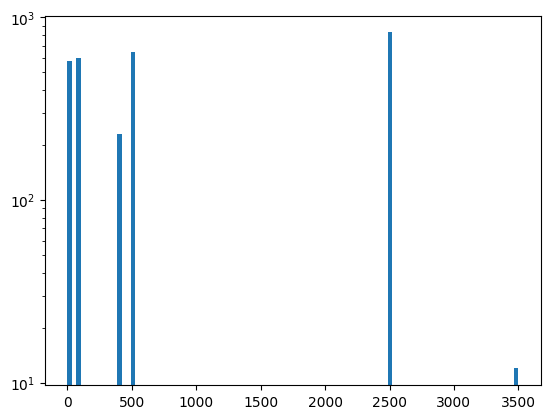

In [469]:
plt.hist([cell.reward for cell in archive.values()], bins=100);
plt.yscale('log')

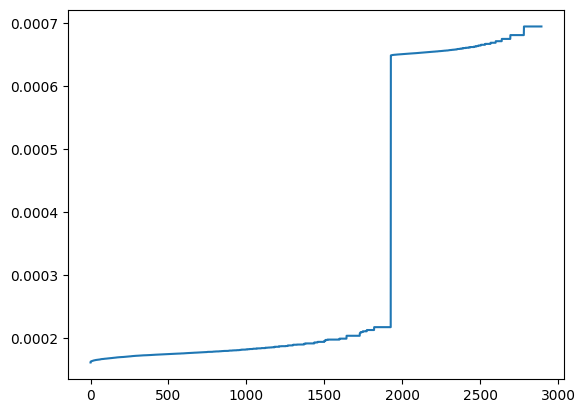

In [470]:
scores = np.array([cell.score for cell in archive.values()])
scores = scores/scores.sum()
plt.plot(scores[scores.argsort()])

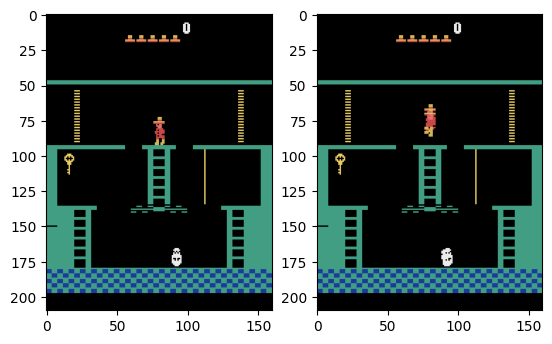

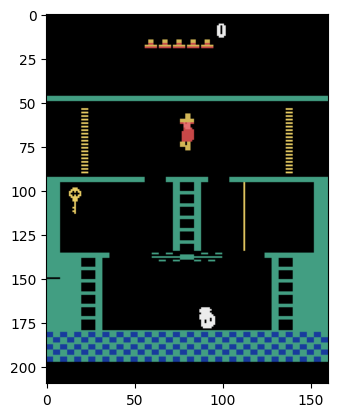

In [185]:
env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=160, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=True)
obs2, _ = env.reset()
obs2 = rearrange(obs2, '1 c h w -> h w c')
plt.subplot(121); plt.imshow(obs2)

obs2, _, _, _, _ = env.step(np.array([0]))
obs2 = rearrange(obs2, '1 c h w -> h w c')
plt.subplot(122); plt.imshow(obs2)
plt.show()

obs2, _, _, _, _ = env.step(np.array([0]))
obs2 = rearrange(obs2, '1 c h w -> h w c')
plt.imshow(obs2)
plt.show()


In [13]:
max([len(cell.trajectory) for cell in cells])

180

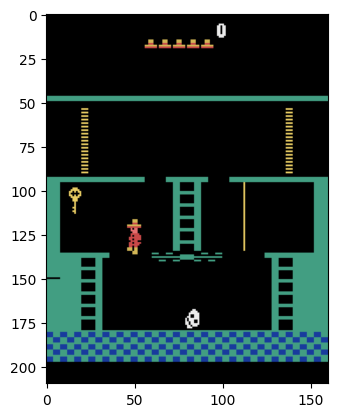

In [14]:
traj = []
env.reset();
for i in range(10):
    a = env.action_space.sample()
    obs, _, _, _, _ = env.step(a)
    traj.append(a)
    state = env.clone_state(True)
    env.reset()
    env.restore_state(state)
state = env.clone_state(True)
obs, _, _, _, _ = env.step(0)
ram = env.ale.getRAM()

plt.imshow(obs)
plt.show()

In [15]:
env.reset()
env.restore_state(state)
obs, _, _, _, _ = env.step(0)
ram1 = env.ale.getRAM()

In [16]:
env.reset()
for a in traj:
    env.step(a)
obs, _, _, _, _ = env.step(0)
ram2 = env.ale.getRAM()

In [17]:
np.allclose(ram, ram1), np.allclose(ram, ram2)

(True, True)

In [36]:
import copy

In [42]:
env = gym.make(f"ALE/{'MontezumaRevenge'}-v5", frameskip=4, repeat_action_probability=0.0)


_, info = env.reset()
max_lives = info["lives"]

archive = defaultdict(lambda: Cell())
highscore = 0
frames = 0
iterations = 0

env = gym.make(f"ALE/{'MontezumaRevenge'}-v5", frameskip=4, repeat_action_probability=0.0)
env.seed(0)
env.action_space.seed(0)
np.random.seed(0)
frame = env.reset()
score = 0
action = 0
trajectory = []
my_iterations = 0

ff = None
for i in range(100):
    found_new_cell = False
    episode_length = 0

    for i in range(100):
        if np.random.random() > 0.95:
            action = env.action_space.sample()

        frame, reward, terminal, trunc, info = env.step(action)
        score += reward
        terminal |= info["lives"] < max_lives
        terminal |= trunc

        trajectory.append(action)
        episode_length += 4

        if score > highscore:
            highscore = score
            best_cell = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        if terminal:
            frames += episode_length
            break
        else:
            cell = cellfn(frame)
            cellhash = hashfn(cell)
            cell = archive[cellhash]
            first_visit = cell.visit()
            if first_visit or score > cell.reward or score == cell.reward and len(trajectory) < len(cell.trajectory):
                
                if cellhash==ff:
                    print('---------', ff)
                    print(first_visit)
                    if not first_visit:
                        print(score > cell.reward)
                        if not score > cell.reward:
                            print(score == cell.reward and len(trajectory) < len(cell.trajectory))
                            print(score, cell.reward, len(trajectory), len(cell.trajectory))
                cell.ram = env.clone_state(True)
                cell.reward = score
                cell.trajectory = copy.deepcopy(trajectory.copy())
                cell.times_chosen = 0
                cell.times_chosen_since_new = 0
                new_cell = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                found_new_cell = True
                if cellhash==ff:
                    print('-')
                    print(first_visit)
                    if not first_visit:
                        print(score > cell.reward)
                        if not score > cell.reward:
                            print(score == cell.reward and len(trajectory) < len(cell.trajectory))
                            print(score, cell.reward, len(trajectory), len(cell.trajectory))
                

    if found_new_cell and my_iterations > 0:
        restore_cell.times_chosen_since_new = 0

    scores = np.array([cell.score for cell in archive.values()])
    hashes = [cellhash for cellhash in archive.keys()]
    probs = scores / scores.sum()
    restore = np.random.choice(hashes, p=probs)
    restore_cell = archive[restore]
    ram, score, trajectory = restore_cell.choose()
    if restore==ff:
        print('restoring root ', len(trajectory))
    env.reset()
    env.restore_state(ram)
    my_iterations += 1
    iterations += 1


--------- -5718259304823463892
True
-
True
restoring root  1
restoring root  1
restoring root  1


In [14]:
cells = np.array([cell for cell in archive.values()])
traj_lens = np.array([len(cell.trajectory) for cell in archive.values()])
traj_rets = np.array([cell.reward for cell in archive.values()])

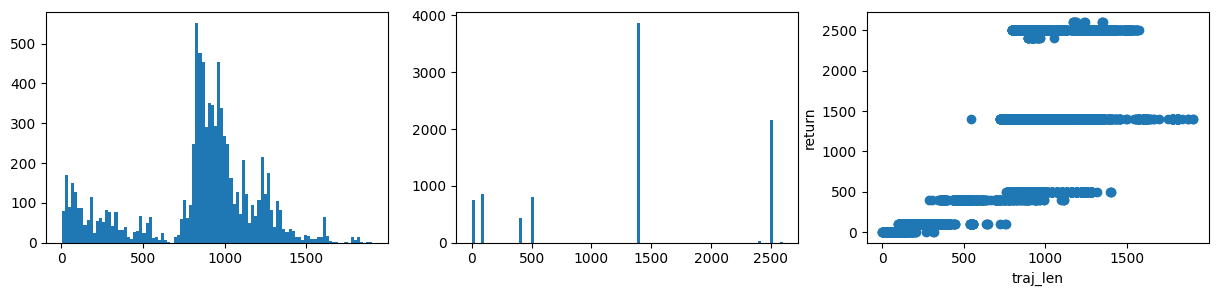

In [15]:
plt.figure(figsize=(15,3))
plt.subplot(131); plt.hist(traj_lens, bins=100);
plt.subplot(132); plt.hist(traj_rets, bins=100);
plt.subplot(133); plt.scatter(traj_lens, traj_rets); plt.xlabel('traj_len'); plt.ylabel('return');

In [16]:
cell = np.random.choice(list(archive.values()))

In [17]:
for _ in tqdm(range(1000)):
    env = envpool.make_gymnasium('MontezumaRevenge-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
    env.reset()
    for a in cell.trajectory[:]:
        obs, _, _, _, _ = env.step(np.array([a]))
        obs = rearrange(obs, '1 c h w -> h w c')

  0%|▌                                                                                                                                                                                                              | 3/1000 [00:03<16:48,  1.01s/it]


KeyboardInterrupt: 

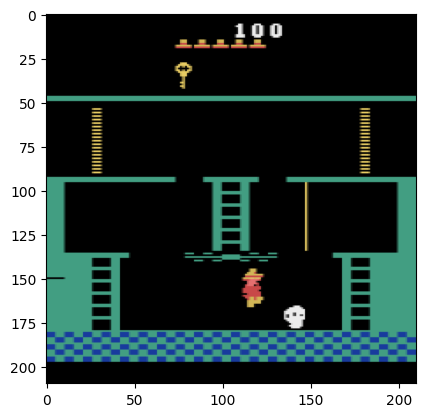

In [20]:
plt.imshow(obs)

In [172]:
env = envpool.make_gymnasium('MontezumaRevenge-v5', num_envs=4, img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env.single_observation_space = env.observation_space
env.single_action_space = env.action_space
env.num_envs = 4

In [173]:
from buffers import Buffer
import torch

In [174]:
cells = np.array([cell for cell in archive.values()])
traj_lens = np.array([len(cell.trajectory) for cell in archive.values()])
traj_rets = np.array([cell.reward for cell in archive.values()])

In [175]:
buf = Buffer(env, 512)
next_obs, _ = env.reset()

cells_current = np.random.choice(cells, size=4, replace=True, p=None)
trajs = np.array([cell.trajectory for cell in cells_current], dtype=object)
traj_lens = np.array([len(traj) for traj in trajs])
i_locs = np.zeros(4, dtype=int)
print(traj_lens)

for _ in tqdm(range(20)):
    for t in range(512):
        buf.obss[:, t] = torch.from_numpy(next_obs)
        action = np.array([traj[i_loc] for traj, i_loc in zip(trajs, i_locs)])
        buf.acts[:, t] = torch.from_numpy(action)
        next_obs, _, _, _, _ = env.step(action)
        i_locs += 1
        id = np.where(i_locs>=traj_lens)[0]
        o, _ = env.reset(id)
        next_obs[id] = o
        i_locs[id] = 0
        cells_current[id] = np.random.choice(cells, size=4, replace=True, p=None)[id]
        trajs = np.array([cell.trajectory for cell in cells_current], dtype=object)
        traj_lens = np.array([len(traj) for traj in trajs])
    print(buf.obss.float().var(dim=(0, 1)).mean().item())

[ 930 1320  983  960]


  5%|██████████▍                                                                                                                                                                                                      | 1/20 [00:01<00:35,  1.89s/it]

452.34368896484375


 10%|████████████████████▉                                                                                                                                                                                            | 2/20 [00:03<00:33,  1.85s/it]

2426.5654296875


 15%|███████████████████████████████▎                                                                                                                                                                                 | 3/20 [00:05<00:31,  1.84s/it]

1578.1588134765625


 20%|█████████████████████████████████████████▊                                                                                                                                                                       | 4/20 [00:07<00:30,  1.93s/it]

2430.583984375


 25%|████████████████████████████████████████████████████▎                                                                                                                                                            | 5/20 [00:09<00:28,  1.87s/it]

1389.6923828125


 30%|██████████████████████████████████████████████████████████████▋                                                                                                                                                  | 6/20 [00:11<00:25,  1.85s/it]

1744.257080078125


 35%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 7/20 [00:13<00:24,  1.87s/it]

1498.883056640625


 40%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                                                             | 8/20 [00:14<00:22,  1.86s/it]

2289.843994140625


 45%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 9/20 [00:16<00:20,  1.89s/it]

2033.125


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 10/20 [00:19<00:19,  1.96s/it]

1121.9951171875


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                             | 11/20 [00:20<00:17,  1.91s/it]

1612.60791015625


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 12/20 [00:22<00:14,  1.86s/it]

2232.91796875


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 13/20 [00:24<00:12,  1.83s/it]

1867.8892822265625


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 14/20 [00:26<00:10,  1.81s/it]

2227.30859375


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 15/20 [00:27<00:09,  1.84s/it]

2219.916259765625


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 16/20 [00:29<00:07,  1.84s/it]

2299.019287109375


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 17/20 [00:31<00:05,  1.86s/it]

2266.40869140625


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 18/20 [00:33<00:03,  1.85s/it]

964.5819091796875


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 19/20 [00:35<00:01,  1.78s/it]

2384.444091796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.85s/it]

2039.3079833984375


In [ ]:
# o = rearrange(buf.obss, 'b t c h w -> b t h w c')

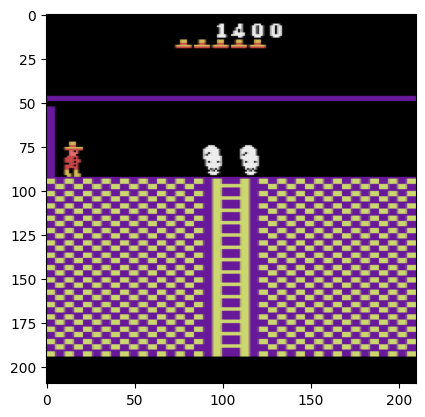

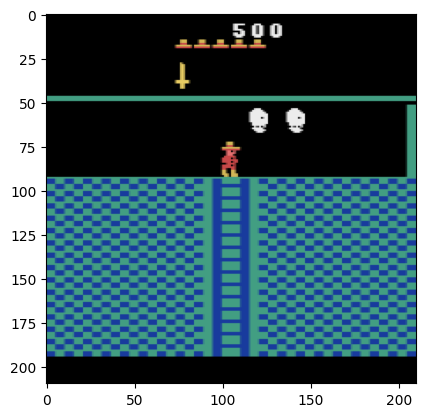

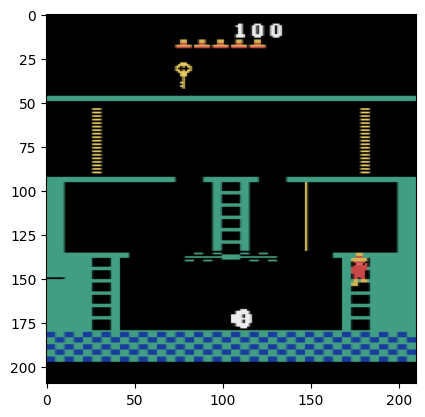

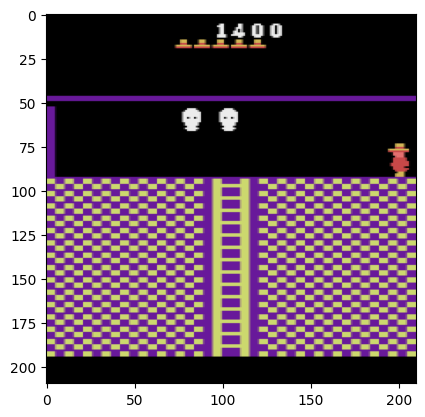

In [142]:
for i in range(4):
    plt.imshow(o[i, -1])
    plt.show()

In [460]:
cells = list(archive.values())

In [475]:
for cell in cells[-20:]:
    print(cell.trajectory[:30])

[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 8, 14, 14, 14, 14, 14, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 14, 14, 14, 

In [457]:
env = envpool.make_gymnasium('Breakout-v5', img_height=210, img_width=210, gray_scale=False, stack_num=1, frame_skip=4, repeat_action_probability=0.0, noop_max=1, use_fire_reset=False)
env.reset();

In [179]:
torch.randn(100, 10, 10).split(30)[0].shape

torch.Size([30, 10, 10])

In [201]:
env = envpool.make_gymnasium('MontezumaRevenge-v5', num_envs=16)

In [202]:
obs, info = env.reset()

In [203]:
info

{'env_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32),
 'players': {'env_id': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
        dtype=int32)},
 'lives': array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32),
 'reward': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'terminated': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'elapsed_step': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)}

In [229]:
def temp(a):
    if isinstance(a, (np.ndarray, torch.Tensor)):
        return rearrange(a, )
a = np.random.randn(10)
temp(a)

TypeError: rearrange() missing 2 required positional arguments: 'tensor' and 'pattern'

In [213]:
a = np.random.randn(10)

In [222]:
rearrange([a,a,a,a], 'a b ... -> (a b) ...').shape

(40,)

In [297]:
env = ConcatEnv([make_env(env_id=env_id, n_envs=8) for env_id in ['Breakout', 'MontezumaRevenge']])
agent = ConcatAgent([RandomAgent(18, ctx_len=4) for _ in range(2)])
# agent = ConcatAgent([NatureCNNAgent(18, ctx_len=1) for _ in range(3)])
buffer = Buffer(env, 10)
buffer.collect(agent, 4)

done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
done: torch.Size([8, 4]), obs: torch.Size([8, 4, 1, 84, 84]), act: torch.Size([8, 3]), rew: torch.Size([8, 3])
d

In [206]:
env.envs[0].get_past_returns()['ret_score']

array([[ 1.,  2.,  1.,  0.,  1.],
       [ 1.,  3.,  0.,  1.,  1.],
       [nan,  4.,  2.,  4.,  0.],
       [ 1.,  1.,  1.,  0.,  2.],
       [ 0.,  1.,  3.,  0.,  0.],
       [ 0.,  0.,  1.,  2.,  1.],
       [ 3.,  1.,  0.,  1.,  0.],
       [nan, nan,  4.,  7.,  2.]])

In [214]:
for envi in env.envs:
    a = envi.get_past_returns()['ret_score']
    print(np.mean(a), np.nanmean(a))

nan 1.4054054054054055
nan 0.0
nan -6.333333333333333


In [87]:
from env_atari import *

In [83]:
env = ConcatEnv([make_env() for _ in range(3)])

In [86]:
obs, info = env.reset()
obs, _, _, _, info = env.step(env.action_space.sample())

RuntimeError: Tensor type unknown to einops <class 'collections.deque'>

In [74]:
for k, v in info.items():
    print(k, type(v), v.shape)

env_id <class 'numpy.ndarray'> (24,)
lives <class 'numpy.ndarray'> (24,)
reward <class 'numpy.ndarray'> (24,)
terminated <class 'numpy.ndarray'> (24,)
elapsed_step <class 'numpy.ndarray'> (24,)
obs <class 'torch.Tensor'> torch.Size([24, 4, 84, 84])
done <class 'torch.Tensor'> torch.Size([24])
timestep <class 'torch.Tensor'> torch.Size([24])


In [79]:
a= b= 3

In [81]:
a, b

(3, 3)